In [63]:
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [64]:
df_train = pd.read_csv('train.csv', index_col='PassengerId')

### Feature Engineering

In [66]:
def feature_engineer(df):
    
    # drop columns not needed
    df.drop(columns=['Ticket','Fare','Cabin'], inplace=True)
    
    # drop rows with NaNs
    df.dropna(subset=['Embarked'], inplace=True)
    
    # extract title from names
    names = []
    for i in df['Name']:
        names.append(i.split(',')[1].split('.')[0].strip())
    df['Title'] = names 

    # normalize the titles
    normalized_titles = {
        "Capt":       "Officer",
        "Col":        "Officer",
        "Major":      "Officer",
        "Jonkheer":   "Royalty",
        "Don":        "Royalty",
        "Sir" :       "Royalty",
        "Dr":         "Officer",
        "Rev":        "Officer",
        "the Countess":"Royalty",
        "Dona":       "Royalty",
        "Mme":        "Mrs",
        "Mlle":       "Miss",
        "Ms":         "Mrs",
        "Mr" :        "Mr",
        "Mrs" :       "Mrs",
        "Miss" :      "Miss",
        "Master" :    "Master",
        "Lady" :      "Royalty"
        }
    
    # map the normalized titles to the current titles 
    df.Title = df.Title.map(normalized_titles)
    df.drop(['Name'], axis=1, inplace=True)

    # replace Age NaNs with median age based on title (stolen code)
    grouped = df.groupby(['Sex','Pclass', 'Title'])  
    df.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))
    df.drop(['Title'], axis=1, inplace=True)

    #average_age = df['Age'].mean()
    #df['Age'] = df['Age'].fillna(average_age)
    
    # turn categories into binary code
    df['Sex'] = pd.factorize(df['Sex'], sort=True)[0]
    one_hot_encoded = pd.get_dummies(df['Embarked'])
    df = pd.concat((df, one_hot_encoded), axis=1)
    df.rename(columns={"C": "C_Embarked"}, inplace=True)
    one_hot_encoded_2 = pd.get_dummies(df['Pclass'])
    df = pd.concat((df, one_hot_encoded_2), axis=1)
    df.drop(['Embarked','Pclass'], axis=1, inplace=True)
    
    # add new column for total number of family members
    df['total_family_on_board'] = df['SibSp'] + df['Parch']
    df.drop(columns=['SibSp','Parch'], axis = 1, inplace=True)
    
    # create new column for survival rate based on family members and then drop family column
    di = {3: 0.724138, 2: 0.578431, 1:0.552795, 6:0.333333, 0:0.300935, 4:0, 5:0, 7:0,10:0 }
    df['survival_rate_family'] = df['total_family_on_board'].map(di) 
    df.drop(['total_family_on_board'], axis=1, inplace=True)

    # fill Cabin NaN with U for unknown
    #df.Cabin = df.Cabin.fillna('U')
    
    # map first letter of cabin to itself
    #df.Cabin = df.Cabin.map(lambda x: x[0])
    
    # turn cabin into binary code
    #one_hot_encoded_cabin = pd.get_dummies(df['Cabin'])
    #df = pd.concat((df, one_hot_encoded_cabin), axis=1)
    #df.rename(columns={"C": "C_Cabin"}, inplace=True)
    #df.drop(['Cabin'], axis=1, inplace=True)
    
    return df

#https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9

In [67]:
df_train = feature_engineer(df_train)

In [68]:
df_train.head(1)

,Survived,Sex,Age,C_Embarked,Q,S,1,2,3,survival_rate_family
PassengerId,,,,,,,,,,
1,0,1,22.0,0,0,1,0,0,1,0.552795


### Data split: test and train

In [69]:
from sklearn.model_selection import train_test_split
X = df_train[['Sex','Age','C_Embarked','Q','S',1,2,3,'survival_rate_family']]
y = df_train['Survived'] 

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [71]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((666, 9), (223, 9), (666,), (223,))

### Random Forest Model

In [72]:
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

### Model Performance

In [73]:
train_score = rf.score(X_train,y_train)

In [74]:
test_score = rf.score(X_test,y_test)

In [75]:
print("My train score is "+str(train_score)+" but my test score is "+str(test_score))

My train score is 0.8513513513513513 but my test score is 0.820627802690583


In [54]:
list(zip(X_train.columns,rf.feature_importances_))

[('Sex', 0.47361284465652487),
 ('Age', 0.16077372174025983),
 ('C_Embarked', 0.01929893925133035),
 ('Q', 0.007984218803727147),
 ('S', 0.02467725708533872),
 (1, 0.060587681822531665),
 (2, 0.021589321616236643),
 (3, 0.1215161148581791),
 ('survival_rate_family', 0.10995990016587164)]

([<matplotlib.axis.YTick at 0x1a1aa1b978>,
 <a list of 9 Text yticklabel objects>)

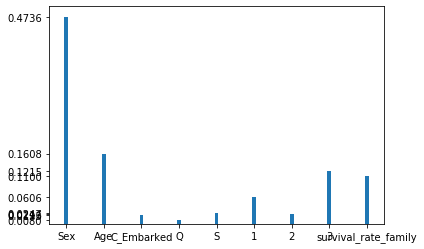

In [62]:
feature_importance = list(zip(X_train.columns,rf.feature_importances_))

labels, ys = zip(*feature_importance)
xs = np.arange(len(labels)) 
width = 0.1

plt.bar(xs, ys, width, align='center')

plt.xticks(xs, labels) 
plt.yticks(ys)

In [28]:
import statsmodels.discrete.discrete_model as sm

# H0 = My coef. is not significant.
# p< 0.05 => I can reject the H0 so my coefficient is significant.


logit = sm.Logit(y_train, X_train)
f = logit.fit()
print(f.params)
print(f.summary())

Optimization terminated successfully.
         Current function value: 0.434008
         Iterations 6
Sex                    -2.571515
Age                    -0.035866
C_Embarked              1.046654
Q                       0.871040
S                       0.548335
1                       1.926327
2                       0.873528
3                      -0.333827
survival_rate_family    2.635967
dtype: float64
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  666
Model:                          Logit   Df Residuals:                      658
Method:                           MLE   Df Model:                            7
Date:                Fri, 11 Oct 2019   Pseudo R-squ.:                  0.3499
Time:                        11:45:06   Log-Likelihood:                -289.05
converged:                       True   LL-Null:                       -444.60
Covariance Type:            nonro

In [29]:
ypred = rf.predict(X)

In [30]:
from sklearn.metrics import confusion_matrix

c = confusion_matrix(y, ypred)

In [31]:
cm = pd.DataFrame(c, index=['Actual-NO', 'Actual-YES'], columns=['Prediction-NO', 'Prediction-YES'])
cm

,Prediction-NO,Prediction-YES
Actual-NO,522,27
Actual-YES,112,228


Text(0.5, 1, 'confusion matrix for Titanic')

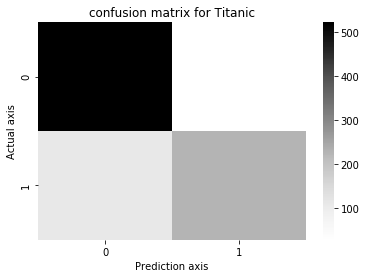

In [32]:
import seaborn as sns

sns.heatmap(c, cmap='Greys')
plt.xlabel('Prediction axis')
plt.ylabel('Actual axis')
plt.title('confusion matrix for Titanic')

### Hyperparameter optimization

In [35]:
##### hyperparameter optimization
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 11, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [37]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
clf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
clf_opt = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf_opt.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 143 out of 150 | elapsed:    7.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.9s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [38]:
clf_opt.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 11,
 'bootstrap': True}

In [39]:
clf_opt.best_estimator_.feature_importances_


array([0.3825045 , 0.28469775, 0.02011975, 0.00882021, 0.02211969,
       0.04557992, 0.02027057, 0.09683275, 0.11905487])

In [41]:
list(zip(X_train.columns,clf_opt.best_estimator_.feature_importances_))


[('Sex', 0.38250449505094514),
 ('Age', 0.28469775373974987),
 ('C_Embarked', 0.020119753876956713),
 ('Q', 0.008820210337267907),
 ('S', 0.02211968567778804),
 (1, 0.04557991720648455),
 (2, 0.02027056803511242),
 (3, 0.0968327468255659),
 ('survival_rate_family', 0.11905486925012945)]

In [42]:
rf.score(X_test,y_test)

0.820627802690583

### Kaggle submission

In [76]:
kaggle_test = pd.read_csv('test.csv')

In [77]:
df_kaggle_test = feature_engineer(kaggle_test.set_index('PassengerId'))

In [78]:
df_kaggle_test.head()

,Sex,Age,C_Embarked,Q,S,1,2,3,survival_rate_family
PassengerId,,,,,,,,,
892,1,34.5,0,1,0,0,0,1,0.300935
893,0,47.0,0,0,1,0,0,1,0.552795
894,1,62.0,0,1,0,0,1,0,0.300935
895,1,27.0,0,0,1,0,0,1,0.300935
896,0,22.0,0,0,1,0,0,1,0.578431


In [83]:
predictions = rf.predict(df_kaggle_test)

output = pd.DataFrame()
output['PassengerId'] = df_kaggle_test.index
output['Survived'] = predictions
output.to_csv('random_forest_02.csv', index=False)

In [84]:
submission = pd.read_csv('random_forest_02.csv', index_col='PassengerId')